**Predicting Algerian Forest Fires**

**Introduction** 

A forest fire is the uncontrolled burning of plants in a natural setting such as a forest, that consumes natural fuels and spreads based on environmental conditions (“Forest Fires”, 2021). These fires can be caused by human actions, extreme drought, or lightning, and can have devastating effects on the environment and human life (“Forest Fires”, 2021). Some countries, such as Algeria, have higher instances of forest fires, as they have longer dry seasons and often lack the infrastructure to control such large fires (Meddour-Sahar, 2015). As such, predicting the onset of forest fires in these regions plays an integral role in the mitigation of this threat. 

For our project, we want to know, “Can we build a model that can accurately predict when forest fires in Algeria will occur in the future, based on weather conditions?” We will investigate this prediction by using the Algerian Forest Fires Dataset, which contains data from two regions of Algeria, but we will focus only on the Bejaia region in order to work with a more manageable data set. There are 11 total variables in this dataset, of which we will use Temperature and Humidity, as we expect these variables to have a significant effect on the the liklihood of forest fires taking place, and using only two variables aligns more with what we have covered in class. There are 122 total observations and the period of data collection is from June of 2012 to September of 2012.

**Methods and Results**

In our preliminary expoloratory data analysis, we first load our libraries, before reading and tidying the data. Next, we create the train/test split that will eventually be used to train and test our classifier. Finally, we create a table summarizing our data before creating visualizations of our data.

In [2]:
#load libraries
library(readxl)
library(tidyverse)
library(tidymodels)
library(dplyr)
library(ggplot2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [17]:
#read data
bejaia_basic<- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv", skip=1, n_max=122)%>%
mutate(Classes=as_factor(Classes)) #convert Classes variable from a character to a factor

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_double(),
  Temperature = col_double(),
  RH = col_double(),
  Ws = col_double(),
  Rain = col_double(),
  FFMC = col_double(),
  DMC = col_double(),
  DC = col_double(),
  ISI = col_double(),
  BUI = col_double(),
  FWI = col_double(),
  Classes = col_character()
)



In [18]:
#tidy data
bejaia_with_date <- tidyr::unite(bejaia_basic, "Date", year, month, day, remove = FALSE,sep = "-" ) #combine year, month and day to make date
bejaia_tidy <- select(bejaia_with_date, Date, month, Temperature, RH, Classes) #select only variables we will be using (Tempearture and Relative Humidity)

In [42]:
#create the train/test split
set.seed(1) #set seed in order to make code reproducible and ensure that it generates the same train/test split each time
bejaia_split <- initial_split(bejaia_tidy, prop=0.75, strata=Classes) #create 75/25 train/test split to train an accurate model + get an accurate evaluation
bejaia_train <- training(bejaia_split)
bejaia_test <- training (bejaia_split)

**Table 1 - Summary Table**

We used a summary table to further explore our training data set. This table is helpful as it indicates whether or not there is a class imbalance in our data.

In [6]:
#summarize training data in a table
num_obs <- nrow(bejaia_train)
bejaia_train %>% group_by(Classes) %>% summarize(n=n(), percentage = n()/num_obs*100)

`summarise()` ungrouping output (override with `.groups` argument)



Classes,n,percentage
<fct>,<int>,<dbl>
not fire,48,51.6129
fire,45,48.3871


We used the group_by and summarize code pattern to see that we have 48 not fire observations (51.6%) and 45 fire observations (48.4%) in our training data set. Because there are similar amounts of both classes, we can see that there is a low risk for class imbalance. 

**Figure 1 - Temperature vs Relative Humidity**

This scatter plot is used as a form of exploratory data analysis to observe the relationship between our two predictor variables. A scatter plot was used because we are looking at the relationship between two quantitative variables. 

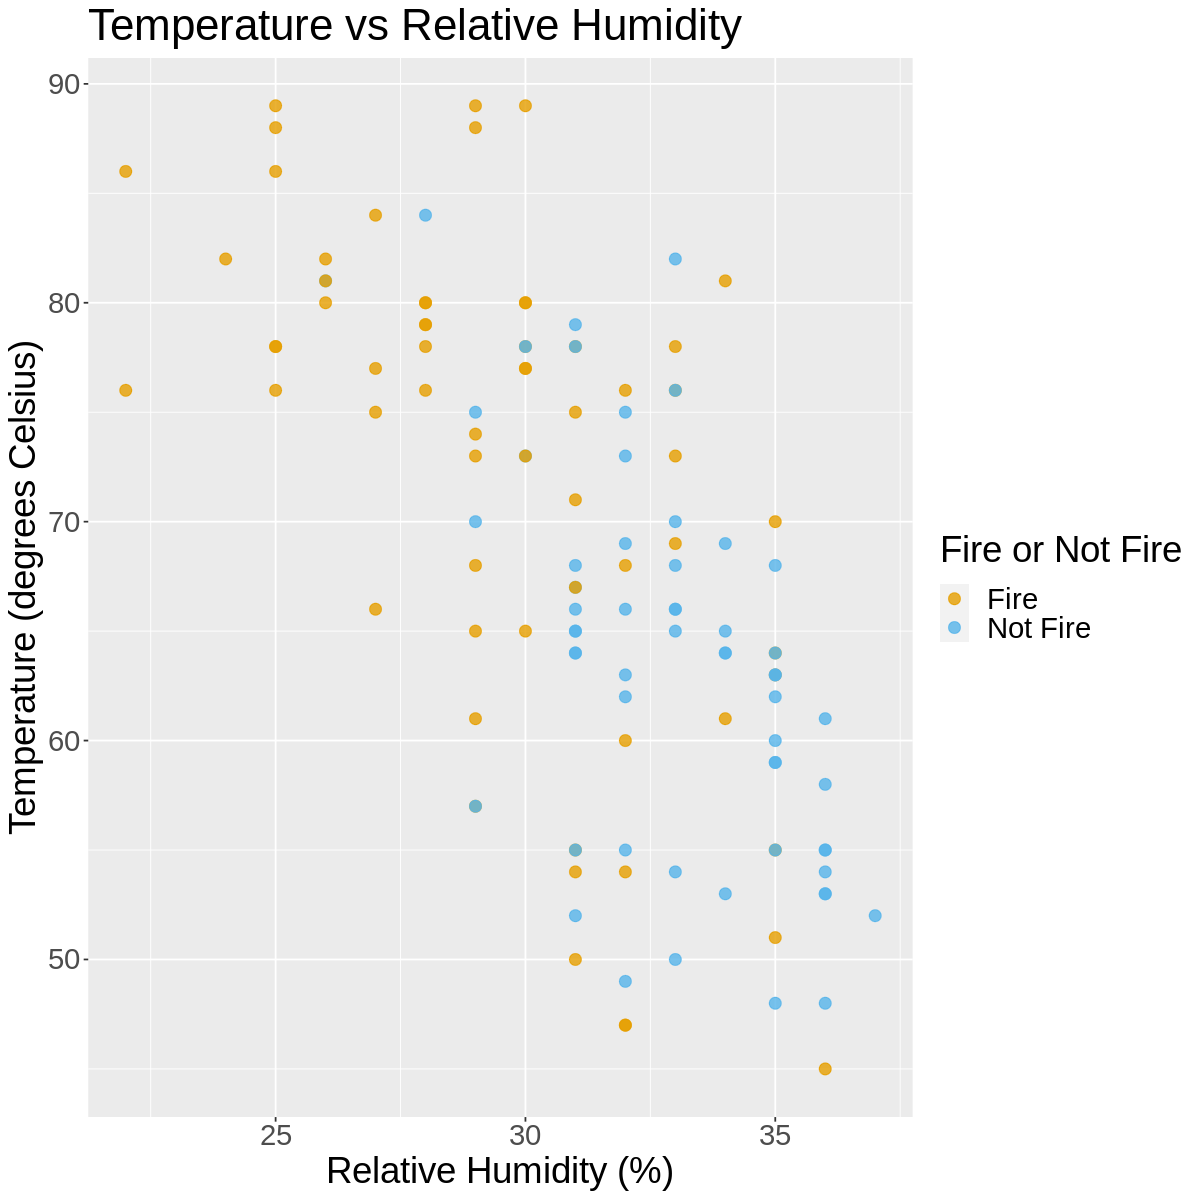

In [9]:
#create a scatterplot to visualize the relationship between our two variables, Temperature and Relative Humidity

cbPalette <- c("#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#999999")
options(repr.plot.width = 10, repr.plot.height = 10)
fire_plot <- bejaia_tidy %>%
ggplot(aes(x = Temperature, y = RH, color = Classes)) +
geom_point(alpha = 0.8, size = 3) +
labs(x="Relative Humidity (%)", y= "Temperature (degrees Celsius)", color = "Fire or Not Fire", shape = "Month") +
scale_color_manual(labels = c("Fire", "Not Fire"), values = cbPalette) +
theme(text = element_text(size = 22))+
ggtitle('Temperature vs Relative Humidity')
fire_plot

By observing this scatterplot, we see that there are more orange points present when temperature is high and relative humidity is low. This suggests that forest fires occur more frequently in conditions with high temperature and low relative humidity. We also see that there are more blue points present when temperature is low and relative humidity is high. This suggests that forest fires occur less frequently in conditions with low temperature and high relative humidity. 

Based on this graph, we expect for our model to predict more fires when the tempearture is high and the relative humidity is low. Conversely, we expect that the model will predict more non-fires when temperature is low and relative humidity is high. 

**Data Analysis**

For our data analysis, we will use weather data observations, including the variables Relative Humidity (RH) and Temperature to predict when forest fires are more likely to occur in the Bejaia region. We omitted the variables from the FWI components, which are derived from the weather data observations. To answer our question, we will use these variables to perform classification and predict when forest fires are more likely to occur. 


In [41]:
#preprocess data
set.seed(1)

#create a recipe that specifies the target and predictor variables
fire_recipe <- recipe(Classes ~ Temperature, RH, data = bejaia_train) %>%
step_scale(all_predictors()) %>%
step_center(all_predictors())

In [54]:
#train the classifier
set.seed(1) #makes the random selection of rows reproducible

#create a model specification with tune()
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

#split up the training data for cross validation
data_vfold <- vfold_cv(bejaia_train, v=5, strata=Classes)

#add recipe and model specification to a workflow
knn_fit <- workflow() %>%
  add_recipe(fire_recipe) %>%
  add_model(knn_spec) %>%
  tune_grid(resamples=data_vfold, grid=10) %>% #tune_grid used to train validation splits to estimate classifier accuracy
  collect_metrics()

accuracies <- knn_fit %>% filter(.metric =='accuracy')

**Figure 2 - Visualization of Analysis**

This visualization displays the accuracy estimate for each value of K, and can be used to help determine the best value of K for our model.

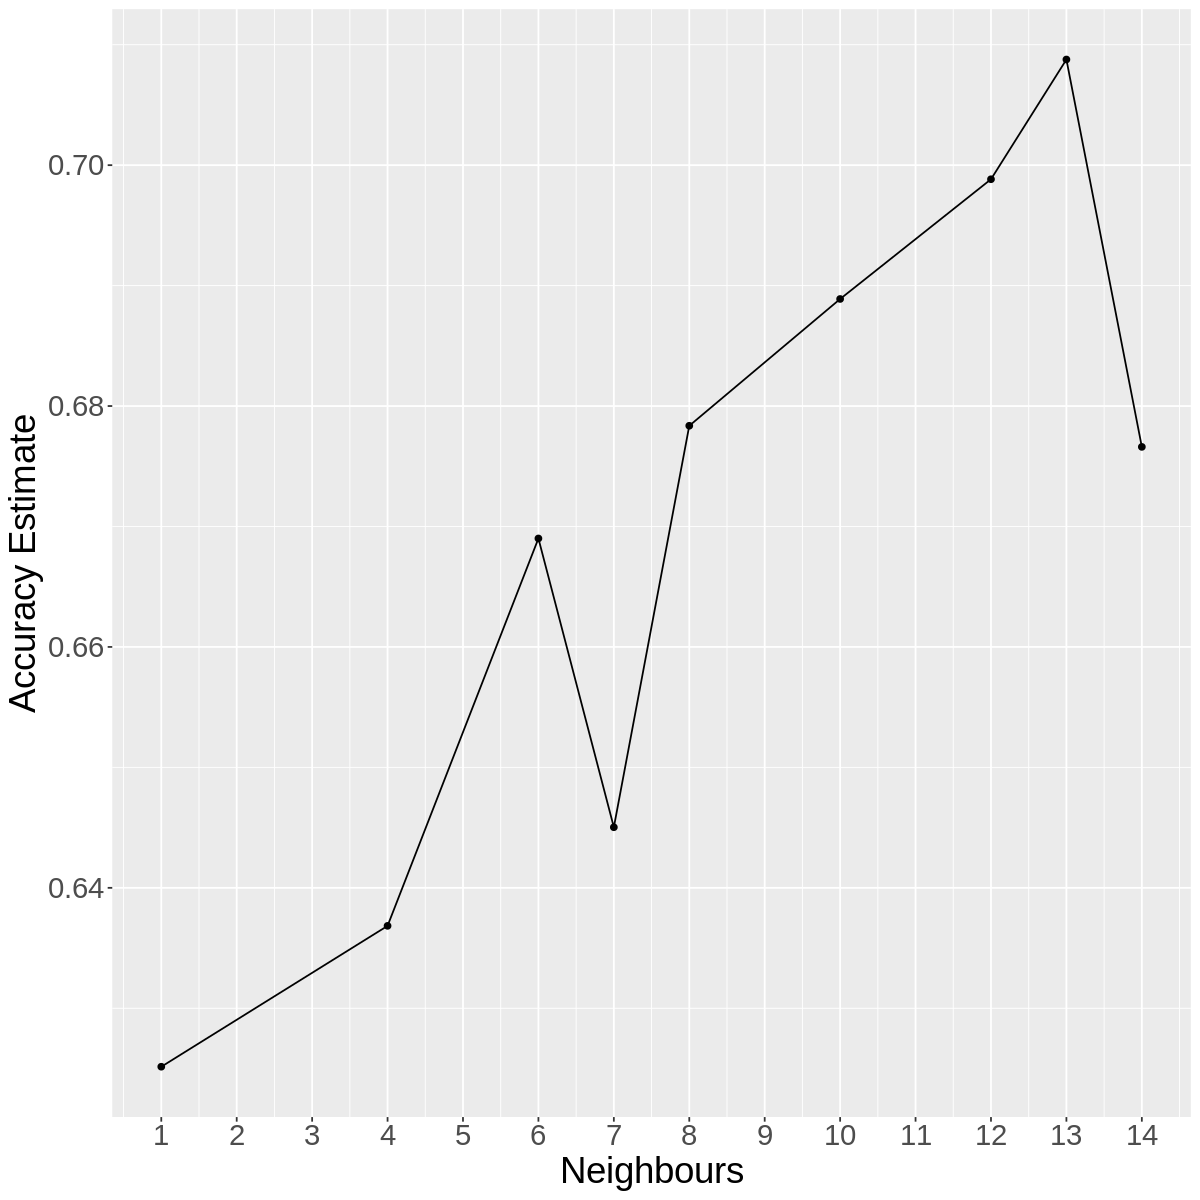

In [45]:
#use plot to pick a value of K that yields a high accuracy estimate
k_plot <- ggplot(accuracies, aes(x=neighbors, y=mean))+
geom_point()+
geom_line()+
labs(x='Neighbours', y='Accuracy Estimate')+
scale_x_continuous(breaks=seq(0,14, by=1))+
theme(text = element_text(size = 22))
k_plot

By observing this graph, we chose K = 13, as it has the highest accuracy estimate (~0.71). 

In [65]:
set.seed(1)

#use the value of K that gives the highest accuracy to build the final model
fire_recipe <- recipe(Classes ~ Temperature, RH, data = bejaia_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())
fire_recipe

fire_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 13) %>% 
set_engine('kknn')%>%
set_mode('classification')
fire_spec

fire_workflow <- workflow()%>%
add_model(fire_spec)%>%
add_recipe(fire_recipe)
fire_workflow

fire_fit <- fit(fire_workflow, data=bejaia_train)
fire_fit

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          1

Operations:

Scaling for all_predictors()
Centering for all_predictors()

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 13
  weight_func = rectangular

Computational engine: kknn 


══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 13
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~13, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2688172
Best kernel: rectangular
Best k: 13

**Table 2 - Predictions**

This table compares the predicted class from our model with the actual class from our test data set in order to determine the accuracy of our model.

In [66]:
set.seed(1)
#predict the labels in the test set
fire_predictions <- predict(fire_fit, bejaia_test) %>% bind_cols(bejaia_test)
fire_predictions

.pred_class,Date,month,Temperature,RH,Classes
<fct>,<chr>,<chr>,<dbl>,<dbl>,<fct>
not fire,2012-06-01,06,29,57,not fire
not fire,2012-06-02,06,29,61,not fire
not fire,2012-06-03,06,26,82,not fire
not fire,2012-06-04,06,25,89,not fire
not fire,2012-06-05,06,27,77,not fire
fire,2012-06-07,06,33,54,fire
not fire,2012-06-08,06,30,73,fire
not fire,2012-06-09,06,25,88,not fire
not fire,2012-06-12,06,26,81,fire


By observing this table, we see that most of the predicted class labels match the class labels of the test data set. To get a more concrete idea of accuracy, we can use the table below.

**Table 3 - Accuracy**

This table indicates the accuracy of the model that we have created.

In [67]:
set.seed(1)
#report the accuracy of the prediction
fire_metrics <- fire_predictions %>% metrics(truth = Classes, estimate= .pred_class)
fire_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7204301
kap,binary,0.4410541


This table indicates that the accuracy of our model is approximately 72%.

**Table 4 - Confusion Matrix**

This table shows which of the predicted labels are correct within our model.

In [69]:
set.seed(1)
#report the confusion matrix
fire_conf_mat <- fire_predictions %>% conf_mat(truth = Classes, estimate= .pred_class)
fire_conf_mat

          Truth
Prediction not fire fire
  not fire       34   12
  fire           14   33

This says that the classifier labelled 34+33 = 67 observations correctly, 14 observations as fire when they were truly not fire, and 12 observations as not fire when they were truly fire.

**Discussion**

In this project, we endeavoured to answer the question "Can we build a model that accurately predicts when forest fires in Algeria will occur, based on weather conditions?". Through classification and cross-validation, we were able to create a model that predicts the liklihood of forest fires in the Bejaia region of Algeria based on temperature and relative humidity, with 72% accuracy. These findings are consistent with our prediction, in which we expected that we would be able to create an accurate model that could predict forest fires. 

Having an accurate means of predicting forest fires would allow residents to be alerted earlier about the risk and could give them more time to prepare or evacuate, resulting in less damage to property and fewer casualties. For example, after being notified about high-risk conditions, civilians could prepare for forest fires by creating emergency kits in case of evacuation, or farmers may trim lawns and tall vegetation to minimize damage (Weir, 2018). This data could lead to future questions, such as how the likelihood of forest fires differs between regions of Algeria. Taking data from other regions could help us better understand how climate conditions differ across Algeria, and how this variation in conditions affects the likelihood of forest fires. 

**References**

Faroudja ABID et al.(2019). Predicting Forest Fire in Algeria using Data Mining Techniques: Case Study of the Decision Tree Algorithm, International Conference on Advanced Intelligent Systems for Sustainable Development (AI2SD 2019), Marrakech, Morocco.

Forest Fire. (2021). UN - SPIDER. Retrieved February 28, 2021,  https://un-spider.org/disaster-type/forest-fire

Meddour-Sahar, O. (2015). Wildfires in Algeria: Problems and challenges. IForest, 8(Dec2015), 818–826. https://doi.org/10.3832/ifor1279-007

Weir, J. R. (2018, July). Wildfire: Preparing the ranch and farm - oklahoma state university. Retrieved March 06, 2021, from    https://extension.okstate.edu/fact-sheets/wildfire-preparing-the-ranch-and-farm.htm


